In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame = False)

In [4]:
X, y = mnist.data, mnist.target
X
X[0].shape

(784,)

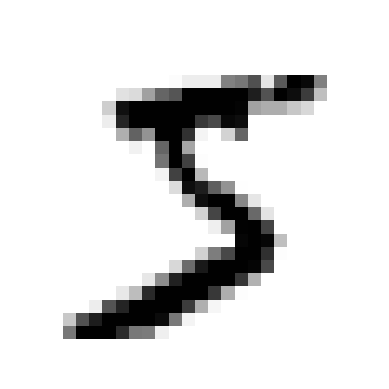

In [24]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [4]:
y[0]

'5'

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

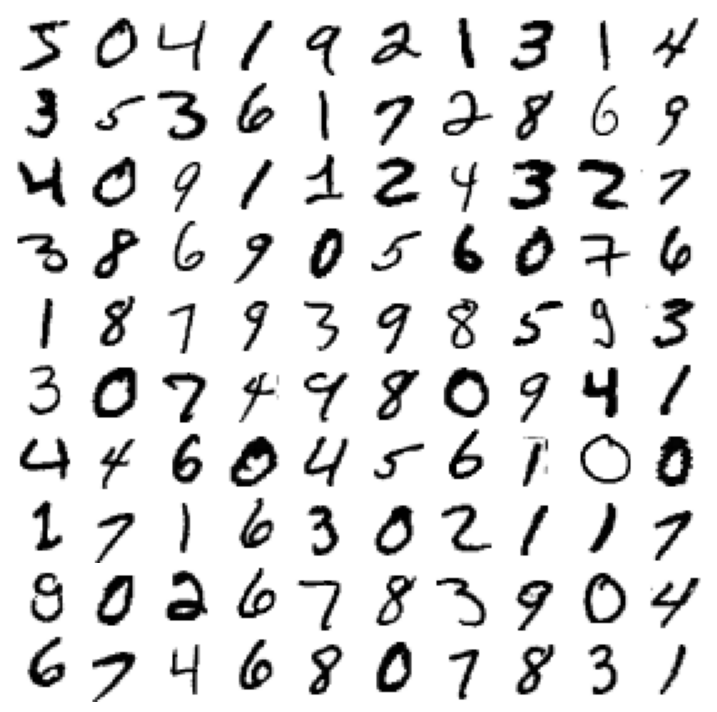

In [6]:
plt.figure(figsize = (9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10,10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()


#### TRAINING A BINARY CLASSIFIER

In [7]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


#### USING CROSS VALIDATION

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy", verbose = 1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s finished


array([0.95035, 0.96035, 0.9604 ])

#### Using a dummy classifier

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))


False


#### Validating dummy classifier

In [11]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.90965, 0.90965, 0.90965])

##### Counting the how many entires are 5
This showed us the reason that the validation is so high because most of the values in the dataset are 5.

In [12]:
count_of_5 = (y_train_5 == True).sum()
print(count_of_5 / len(y_train_5))
# print(y_train_5)

0.09035


#### Implementing a confusion matrix


In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [14]:
# y_train_pred_int = y_train_pred.astype(int)
# y_train_pred

##### Each row in a confusion matrix represents an actual class, whereas each column represents a predicted class.

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

#### Suppose we have the perfect confusion matrix, it will non zero values in its main diagonal

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

#### precision of classifier
precision = TP / (TP + FP), where TP = True positives & FP = false positives

#### recall / sensitivity / true positive rate
recall = TP /(TP + FN)


#### Implementing precison and recall 

In [17]:
from sklearn.metrics import precision_score, recall_score
print(f" precision score - {precision_score(y_train_5, y_train_pred)}")
print(f"recall score - {recall_score(y_train_5, y_train_pred)}")


 precision score - 0.8370879772350012
recall score - 0.6511713705958311


The classifier is only correct 83.7% of times, whereas it only detects 65.1% of 5's.

#### F1 Score
This is harmonic mean of precision and recall, giving much more weight to low values. F1 will only be high when both precision and recall are high.

In [18]:
from sklearn.metrics import f1_score
print(f"f1 score - {f1_score(y_train_5, y_train_pred)}")

f1 score - 0.7325171197343847


#### Decision function
Looking at how SGDClassifier makes its classification decisions using a decision fucntion which will help understand precision/recall trade off

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
print(f"y score - {y_scores}")

y score - [2164.22030239]


In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The above code shows that by increasing the threshold, precision increases but recall decreases.

#### Which threshold to use?
First we use cross_val_predict function to get decison scores of all instances in the training set.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = "decision_function")

Now with these scores we use precision_recall_curve which returns precison, recall and threshold used for calculating the first two.
Basically, it uses different thresholds and calculates P and R to find the best threshold.

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

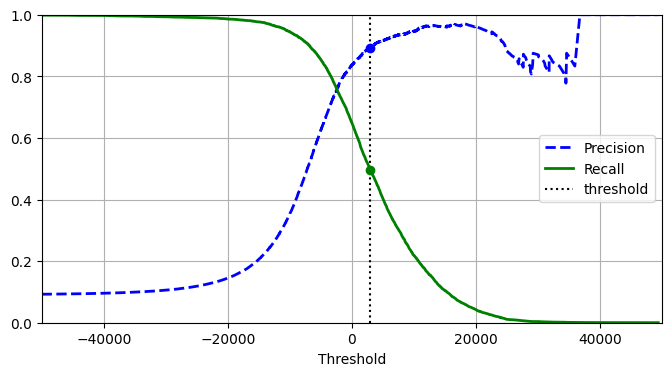

In [24]:
plt.figure(figsize = (8, 4))
plt.plot(thresholds,precisions[:-1], "b--", label = "Precision",  linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label = "threshold")
#We use 3000 to draw a vertical line as a refrence threhold

idx = (thresholds >= threshold).argmax()
#argmax returns the index of first occurance of max value in an array
plt.plot(thresholds[idx], precisions[idx],"bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc = "center right")
plt.show()

PLotting precision recall curve

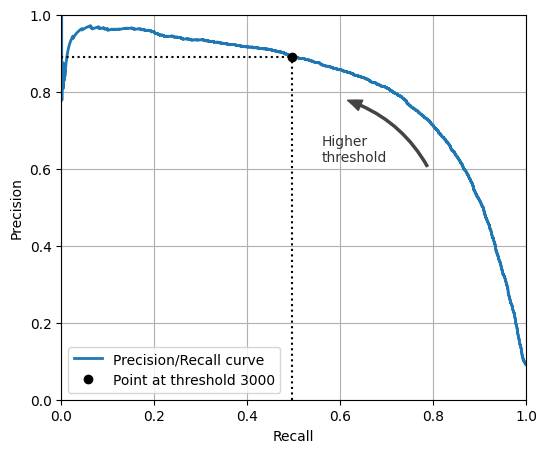

In [25]:
import matplotlib.patches as patches

plt.figure(figsize = (6,5))
plt.plot(recalls, precisions, linewidth = 2, label = "Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], "k:")
plt.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot(recalls[idx], precisions[idx], "ko", label = "Point at threshold 3000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78), connectionstyle="arc3, rad=.2",
    arrowstyle="Simple, tail_width = 1.5, head_width = 8, head_length = 10",
    color="#444444"
))
plt.text(0.56, 0.62, "Higher\nthreshold", color = "#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc = "lower left")

plt.show()


Suppose we go for atleast 90% precision

In [26]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

Instead of calling predict, we can also check their y_scores(distances) and compare them to threshold.

In [27]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(f" Precison score for the above threshold - {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall score for the above threshold - {recall_score(y_train_5, y_train_pred_90)}")

 Precison score for the above threshold - 0.9000345901072293
Recall score for the above threshold - 0.4799852425751706


#### TIP
If someone says, "Let's launch 99% precision", you should ask, "At what recall?"

#### Receiver Operating Characteristic(ROC) Curve
It plots True Positive Rate(recall) versus False Positive Rate(Fall-out)
FPR is the rate of labeling an instance as positive when it actually is negative, as the name implies False Positive.

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [29]:
# thresholds
print(f"Note that the thresholds are in decreasig order this time.\n{thresholds}")

Note that the thresholds are in decreasig order this time.
[             inf   49441.43765905   36801.60697028 ... -105763.22240074
 -106527.45300471 -146348.56726174]


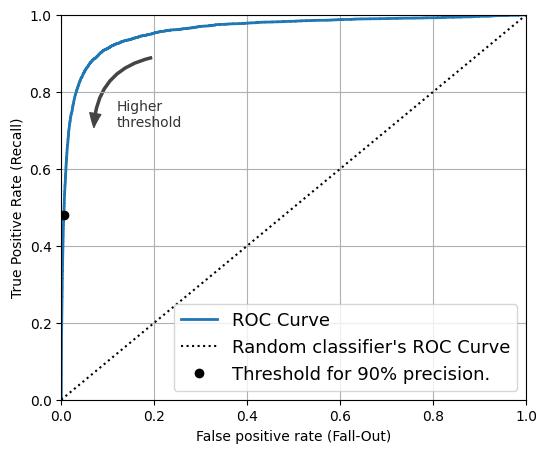

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0,1], "k:", label="Random classifier's ROC Curve")

plt.plot(fpr_90, tpr_90, "ko", label="Threshold for 90% precision.")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.2,0.89), (0.07, 0.70),
    connectionstyle="arc3, rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"
))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False positive rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0,1,0,1])
plt.legend(loc="lower right", fontsize=13)


plt.show()

A good classifier stays away from thr straight line as far as possible, in the top left corner.

#### AOC AREA UNDER THE CURVE
Comparing Classifiers using Area under the curve.Comparing Classifiers using Area under the curve.

In [31]:
from sklearn.metrics import roc_auc_score
print(f"AUC Score - {roc_auc_score(y_train_5, y_scores)}")

AUC Score - 0.9604938554008616


Creating a RandomForestClassifier to compare to SGDClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [33]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method="predict_proba", cv=3)

In [34]:
y_probas_forest[:2]
# y_train_5[:2]


array([[0.11, 0.89],
       [0.99, 0.01]])

89% probability is for positive class.
Also these are estimated probabilities. Among the images, the model classified with a probs between 50% & 60%, there are actually about 94% positive images.

In [35]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{y_train_5[idx_50_to_60].sum() / idx_50_to_60.sum():.1%}")

94.0%


How to identify which probs belong to positve and which to negative. IDK

In [36]:
# print(f"Sorted order of classifier - {forest_clf.classes_b
#}")

In [37]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest,thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)


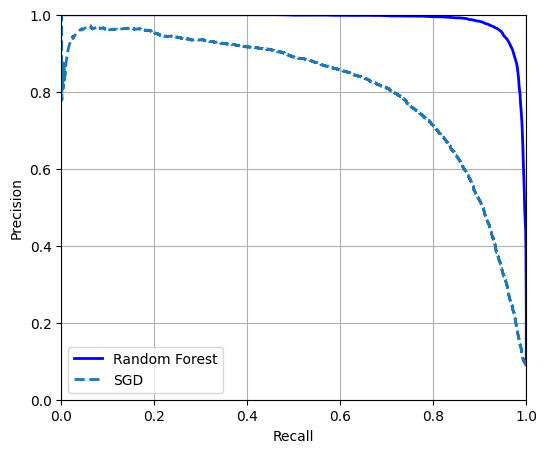

In [38]:
plt.figure(figsize=(6,5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, 
         label="Random Forest")
plt.plot(recalls, precisions,"--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [39]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
y_train_pred_forest

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [40]:
print(f"F1 score for random forest classifier - {f1_score(y_train_5, y_train_pred_forest)}")

F1 score for random forest classifier - 0.9274509803921569


In [41]:
print(f"AUC Score for random forest classifier - {roc_auc_score(y_train_5, y_scores_forest)}")

AUC Score for random forest classifier - 0.9983436731328145


In [42]:
print(f"Precision score for Random forest-{precision_score(y_train_5, y_train_pred_forest)}")
print(f"Recall scores for Random forest-{recall_score(y_train_5, y_train_pred_forest)}")

Precision score for Random forest-0.9897468089558485
Recall scores for Random forest-0.8725327430363402


#### MULTICLASS CLASSIFICATION

In [43]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [44]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

Scikit-learn actually trained 45 classifiers for this and used the One versus One strategy.

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)


array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [46]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

When a classifier is trained, the target classes are stored in classes_ attribute.

In [47]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [48]:
svm_clf.classes_[class_id]

'5'

You can explicitly state which strategy to use.

In [49]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [50]:
ovr_clf.predict([some_digit])


array(['5'], dtype='<U1')

In [51]:
print(f"The number of classifiers trained - {len(ovr_clf.estimators_)}")

The number of classifiers trained - 10


Training an SGDClassifier is just as easy.

SGSClassifier is actually a Linear model with stochastic gradient descent learning.

In [52]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

This time scikit learn used the OvR strategy under the hood. Since there 10 classes, 10 binary classifiers were trained.

In [53]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

The scores here represent the distance between the data point & the hyperplane. As you can see, it not very confident about any of them.

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Scaling the dataset increases accuracy as this puts the values on a similar scale ensuring all values contribute equally. This also helps to converge faster and reduces the chances of getting struck in a local minima.

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

#### Error Analysis

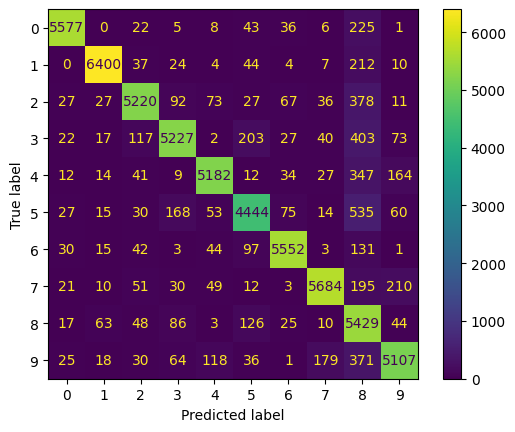

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

Now, the number 4444 above can mean two things-

1)There are simply fewer 5's, which makes the number dark.

2)The model actually identified very less 5's than it was shown, basically showing the poor performance on classifying 5.

For these two reasons, it is important to normalize this data.

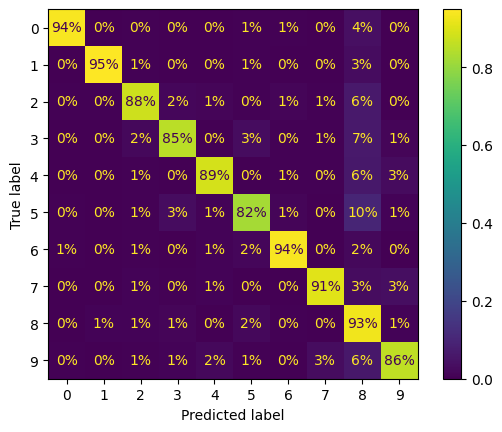

In [57]:
#NORMALIZED MATRIX
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

Now, each cell on the matrix shows recall.82% tells that the model correctly identified only 82% of the 5's it was shown.

##### To make the error stand out more.
To do this, we assign 1 weights to the errors and 0 to the correct. We do this by creating a boolean array which has true when the error occured.

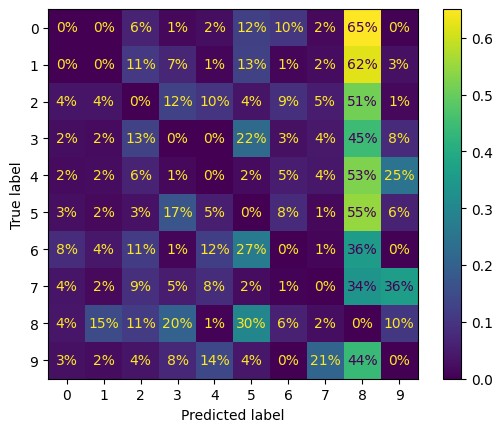

In [58]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

The x% here shows that the out of all the errors the model made(on classifying a particular digit), x% of those total errors were made on the column number. 

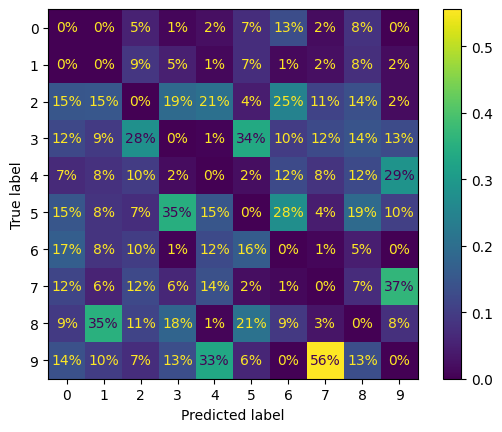

In [59]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")

We can see most of the errors were on false 8's meaning that the classifier was not able to properly understand the digit 8.

We can solve this by collecting more data(adding the images that look like an 8 but are not), preprocessing them to make some patterns or writing some algorithm.

Analyzing individual errors can also be a good way. For ex, lets plot 3 and 5 in a confusion matrix style.

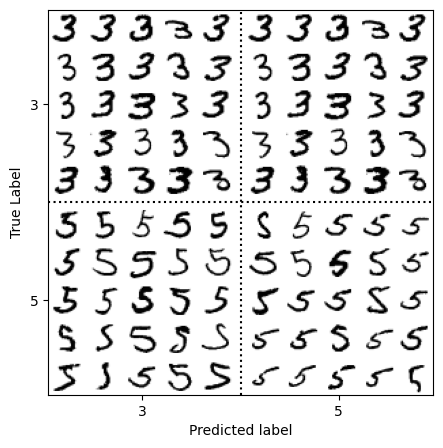

In [60]:
cl_a, cl_b = "3", "5"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))

for images, (label_col, label_row) in [(X_ba, (0,0)), (X_bb, (1,0)), (X_aa, (0,1)), (X_aa, (1,1))]:
    for idx, images in enumerate(images[:size * size]):
        x = idx % size + (label_col * (size + pad))
        y = idx // size + (label_row * (size + pad))
        plt.imshow(images.reshape(28, 28), cmap="binary", extent=(x, x+1, y, y+1))

plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2 ], [0 , 2 * size + pad ], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True Label")

plt.show()


#### MULTILABEL CLASSIFICATION
This refers to outputting multiple classes for each instance, for ex - classifying a digit as large AND if it even. 

In [61]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype(np.int8) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

Evaluating how the mutlilabels perform, one is to calculate F1 score for each class/label and compute the average.

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)


In [64]:
print(f"The f1 score is {round(f1_score(y_multilabel, y_train_knn_pred, average="macro"), 4)}")
print("By taking average as macro,we are giving equal weight to both the labels.")

The f1 score is 0.9764
By taking average as macro,we are giving equal weight to both the labels.


In [65]:
print("Now taking, aveerage as weighted to give more importance to the labels which are more.")
print(f"The weighted f1 score is {round(f1_score(y_multilabel, y_train_knn_pred, average="weighted"), 4)}")

Now taking, aveerage as weighted to give more importance to the labels which are more.
The weighted f1 score is 0.9778


If we want to use a model which does not support multilabel classification, such as SVC, we can train one model per label( one SVC for odd and another for large classfication), and then chain the outputs of both.

In [66]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv = 3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])


,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [67]:
chain_clf.predict([some_digit])

array([[0., 1.]])

#### Multioutput Classification
A generalization of Multilabel Classification, but here each label can have multiple classes(i.e., it can have more than two values.)

For ex - A system that removes noise from images. The output is a clean image(an array of pixels and as each pixel can have values between 0 and 255).

In [68]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
# X_train.shape
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


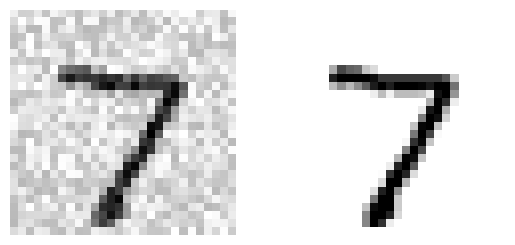

In [69]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

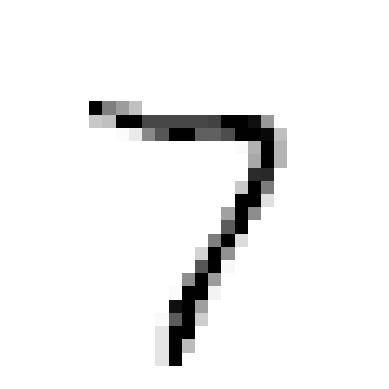

In [70]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

### Exercises

##### 1. An MNIST Classifier with over 97% accuracy

In [71]:
X_train.shape
# y_train.shape

(60000, 784)

In [72]:
knn_clf_mnist = KNeighborsClassifier()
knn_clf_mnist.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [73]:
initial_accuracy = knn_clf_mnist.score(X_test, y_test)

In [74]:
initial_accuracy

0.9688

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_neighbors": [3,4,5,6,7]},
    {"weights": ["uniform", "distance"]}
]

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv = 5)

In [76]:
grid_search.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...]}, {'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


In [77]:
grid_search.best_params_

{'weights': 'distance'}

In [78]:
print(f"The accuracy score is - {grid_search.best_score_}")
print("Exercise done. More than 97% accuracy achieved.")

The accuracy score is - 0.9704166666666667
Exercise done. More than 97% accuracy achieved.


In [79]:
grid_search.best_estimator_

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [80]:
alternate_knn = KNeighborsClassifier(weights="distance", n_neighbors=4)
alternate_knn.fit(X_train, y_train)
alternate_knn.score(X_test, y_test)

0.9714

##### 2 Data Augmentation

In [81]:
# X_train[2][:28]
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

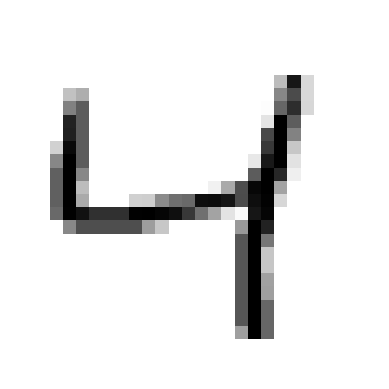

In [82]:
plot_digit(X_train[2])
plt.show()

In [83]:
digit = X_train_copy[0]
digit_matrix = digit.reshape(28, 28).copy()
# digit_matrix
temp = digit_matrix[:,0:1]
# temp.shape
for i in range(27):
    digit_matrix[:,i :i + 1] = digit_matrix[:, i+1:i+2]
digit_matrix[:,27:28] = temp


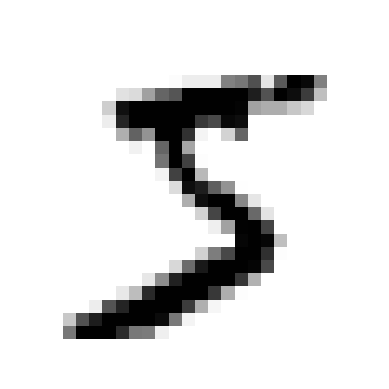

In [84]:
plot_digit(digit)

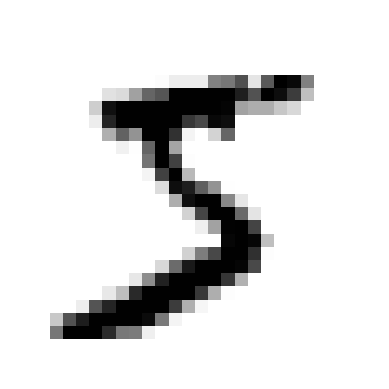

In [85]:
plot_digit(digit_matrix)

In [86]:
print((digit_matrix == digit.reshape(28, 28)).sum())
np.array_equal(digit.reshape(28,28), digit_matrix)

635


False

In [8]:
from scipy.ndimage import shift
def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval = 0, mode="constant")
    return shifted_image.reshape([-1])


# shifted_image_down = shift_image(digit, 0, 5)
# plot_digit(shifted_image_down)


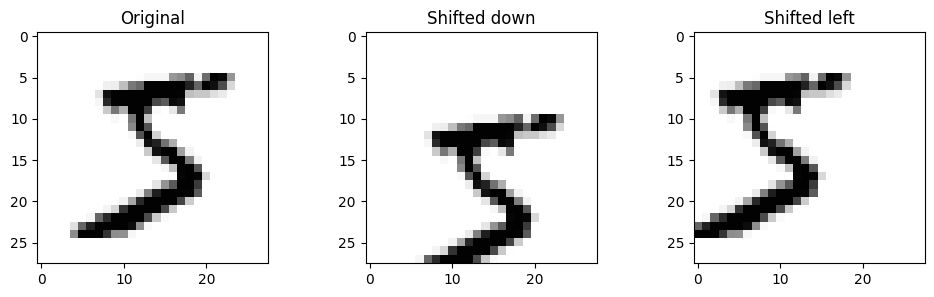

In [88]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(digit.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shift_image(digit, 0, 5).reshape(28,28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shift_image(digit, -5, 0).reshape(28,28), interpolation="nearest", cmap="Greys")

plt.show()

We use python for appending data because in numpy whenever we insert(append), a new array is created in memory.

In [ ]:
# plot_digit(X_)

In [29]:
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (-1, 0), (0,1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


np.random.shuffle was the bit of code which took 1 day to fix. Remember kids, always shuffle your indices correctly.

In [30]:
np.random.seed(42)
shuffle_index = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_index]
y_train_augmented = y_train_augmented[shuffle_index]
# np.random.shuffle(X_train_augmented)
# np.random.shuffle(y_train_augmented)

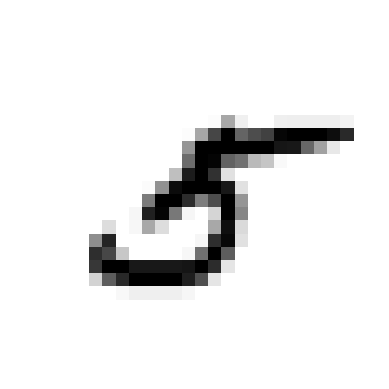

In [31]:
plot_digit(X_train_augmented[0])

In [33]:
y_train_augmented[0]

np.str_('5')

In [94]:
param_grid

[{'n_neighbors': [3, 4, 5, 6, 7]}, {'weights': ['uniform', 'distance']}]

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {"n_neighbors": [3,4,5,6,7]},
    {"weights": ["uniform", "distance"]}
]

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), cv = 3, param_grid = param_grid)
grid_search.fit(X_train_augmented[:30000], y_train_augmented[:30000])
grid_search.best_params_

{'weights': 'distance'}

In [39]:
grid_search.best_score_

np.float64(0.9464666666666667)

In [20]:
X_train_augmented.shape

(300000, 784)

In [64]:
import psutil

def check_memory(size = 0, threshold_ratio = 0.8):
    available_memory = psutil.virtual_memory().available
    total_memory = psutil.virtual_memory().total
    if size !=0:
        size = size / (1024 ** 3)
        print(f"The size of your array {size:.2f} GB.")


    print(f"The available memory is {available_memory / (1024 ** 3):.2f} GB.")
    print(f"The total memory is {total_memory / (1024 ** 3):.2f} GB.")

    if size > available_memory * threshold_ratio:
        print("Not enough space to process that size.")

check_memory()

The available memory is 1.86 GB.
The total memory is 11.41 GB.


In [59]:
knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4)
knn_clf.fit(X_train_augmented[:200000], y_train_augmented[:200000])
knn_clf.score(X_test, y_test)

0.9739

#### 3 Titanic Dataset

In [ ]:
# from pathlib import Path
# import pandas as pd
# import tarfile
# import urllib.request

# def load_titanic_data():
#     tarball_path = Path("datasets/titanic.tgz")

#     if not tarball_path.is_file():
#         Path("datasets").mkdir(parents=True, exist_ok = True)
#         url = "https://github.com/ageron/data/raw/main/titanic.tgz"
#         urllib.request.urlretrieve(url, tarball_path)
#         with tarball_path.open(tarball_path) as titanic_tarball:
#             titanic_tarball.extractall(path="datasets")
#         return 
